# Project 3 - Web APIs & NLP

## Content

1. [Problem statement](#problem-statement)
2. [Data collection](#Data-collection)
3. [Data cleaning](#Data-cleaning)
4. [EDA](#EDA)
5. [Modeling](#Modeling)
6. [Evaluation](#Evaluation)
7. [Conclusions and recommendations](#Conclusions-and-recommendations)

## Problem Statement

WhatToWatch.com is a new platform for movie and tv shows lovers to share their reviews by posting on the community forum. <br>
Currently, there's no category filter to differentiate the posts in the forum. To improve user experience, the marketing team would like to create two categories in the forum to separate the posts - Netflix posts and Amazon Prime Video posts. <br>
This will allow users to read posts based on Netflix and Amazon Prime Video respectively as there's feedback that users are more keen to read posts of the platform they are using so they can see what movies or tv shows would same-platform users recommend. 

WhatToWatch company has approached Skippy's data science team, which I'm in, to help create and train a classification model that can classify posts into the correct category taking reference from the targeted subreddits - Netflix and Amazon Prime Video.<br>

Our team pulled the data via PushShift API and selected 3 classification models to train the models. We will then chose the model with the best accuracy score since the data pulled are of equal classes. <br>

With the best model selected, Skippy's data science team would be able to use it to segregate WhatToWatch.com forum posts into Netflix and Amazon Prime Video respectively and achieve WhatToWatch company's objective. And moving forward, the model will help them to automatically allocate new post to the correct category.<br>

Our data science team can make use of this modeling to help with other clients' projects that requires classification  since the framework is already there.

## Importing libraries

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import re
import nltk

from matplotlib_venn import venn2
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

## **Data collection**

In [2]:
# create a function to pull posts per reddit

def PushShiftdata(url, params, total_num=1000):
    not_reach_total_num = True
    res_list = []
    current_num = 0

    # while this is True:
    while not_reach_total_num:

        # using requests with pushshift api link to pull the data
        res = requests.get(url, params) 

        # get the last row's date in every pull
        params['before'] = res.json()['data'][-1]['created_utc']

        # save the data in a dataframe with only subreddit, selftext and title columns
        res = pd.DataFrame(res.json()['data'])
        res = res.loc[:, ['subreddit', 'selftext', 'title']]

        # append the data to the empty list created earlier
        res_list.append(res)

        # set time.sleep so it will pause awhile for every pull, else Pushshift might block me from pulling the data
        time.sleep(3)

        # count the number of rows
        current_num = current_num + len(res)

        if current_num >= total_num:
            not_reach_total_num = False

    res = pd.concat(res_list)
    return res

In [3]:
# define the url to be used in the function
url = 'https://api.pushshift.io/reddit/search/submission/'

# set params to pull Netflix data, with 100 rows for every pull, before epoch time 1622642695
netflix_params = dict(subreddit='netflix', size=100, before='1622642695')

# apply the function to pull Netflix submissions 
netflix_df = PushShiftdata(url, netflix_params, 1000)
netflix_df.head()

,subreddit,selftext,title
0,netflix,[removed],Any movie or series recommendations
1,netflix,"I want to download from Netflix, but not by ju...",Downloading
2,netflix,[removed],Downloading
3,netflix,,Season 5 of Kim's Convenience is now on Netflix.
4,netflix,I've used other people's Netflix accounts for ...,How do the Netflix subscription accounts work?


In [4]:
# set params to pull AmazonPrimeVideo data, with 100 rows for every pull, before epoch time 1622642695
amazon_params = dict(subreddit='AmazonPrimeVideo', size=100, before='1622642695')

# apply the function to pull AmazonPrimeVideo submissions 
amazon_df = PushShiftdata(url, amazon_params, 1000)
amazon_df.head()

,subreddit,selftext,title
0,AmazonPrimeVideo,[removed],Different video selections on different devices
1,AmazonPrimeVideo,I can't find the English sub or dub version fo...,Can't find the English version for Naruto (Can...
2,AmazonPrimeVideo,,Mary J Blige's My Life - Official Trailer | Pr...
3,AmazonPrimeVideo,,Producers on Amazon's 'Prisma' Where Twins Cha...
4,AmazonPrimeVideo,New to prime video im watching “the office”. I...,Prime Video is skipping episodes and seasons!


I have created a fucntion to pull data using the PushShift API. As I can only pull 100 rows each time, a custom function is necessary to gather more data. Using the function, I pulled 1000 rows of 'selftext' and 'title' for each subreddit.

## **Data cleaning**

**Missing values**<br>
There are missing values in 'selftext' column as seen above which is okay since there's data in 'title' column. <br>
There are some selftext that were removed or deleted, so I will remove them first.

**Outliers**<br>
In NLP, outliers doesn't exist since we are dealing with words but if there is, I would say it's those non-English words and also numerical values.

In [5]:
# create a function to clean the data
def clean_data(df):

    # remove [removed] and [deleted]
    df = df.replace('[removed]', '')
    df = df.replace('[deleted]', '')

    # combine 'selftext' + 'title' to form a new column then drop them
    df['text'] = df['selftext'] + df['title']
    df.drop(['selftext', 'title'], axis=1, inplace=True)

    # drop null values and duplicate rows
    df = df.dropna().drop_duplicates()

    # convert the text to all lowercase 
    #(CountVectorizer & TF-IDF Vectorizer default setting do this but I will just do it anyway)
    df['text'] = df['text'].str.lower()

    return df

The function above cleans the data by removing '[removed]' and '[deleted]', then combine both 'selftext' and 'title' column before dropping null values and duplicate values. I have also converted the text to all lowercase as well though CountVectorizer and TF-IDF Vectorizer do it.

In [6]:
def pos_tag_wordnet(text):

    # keep only alphabets
    text = re.sub(r'[^a-z]', ' ', text)

    # remove stopwords before lemmatize to minimise cases such as 'was' --> 'wa'
    stop_words = stopwords.words('english')
    stop_words.extend(['blah', 'www', 'http'])

    words = text.split()

    full_text = ''
    for word in words:
        if word not in stop_words:
            full_text += word + ' '

    # create a list of wordnet output
    wordnet_map = {
      "N": wordnet.NOUN,
      "V": wordnet.VERB,
      "J": wordnet.ADJ,
      "R": wordnet.ADV
    }

    # tokenize the words and determine the correct Part of speech(POS) tag for every word. 
    # Eg: ('the', 'DT'), ('cat', 'NN')
    pos_tagged_text = nltk.pos_tag(nltk.word_tokenize(full_text))

    # replace the POS tag with wordnet map dictionary created above
    pos_tagged_text = [
          (word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys()
          else (word, wordnet.NOUN)
          for (word, pos_tag) in pos_tagged_text]

    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = " "

    for word, tag in pos_tagged_text:
        lemmatized_sentence += (lemmatizer.lemmatize(word, tag) + ' ')

    return lemmatized_sentence

I have created another function to clean the data further.<br>
There are non-English words and numerical values that are not useful for modeling later on. So I used RegEx to keep only alphabets.<br>
I have included extra stop words as I found that it appears when I vectorize using bigram.<br>
I remove the stopwords before lemmatizing to minimise word not lemmatized correctly. <br>
Lemmatizing prevents counting instances of the root word (such as 'watch', 'watched', 'watches') separately. <br>
In order to lemmatize correctly based of part-of-speech tagging, I created a dictionary to map the POS tag.

In [7]:
# apply both functions to the dataframe
netflix_df = clean_data(netflix_df)
netflix_df['text'] = netflix_df['text'].apply(pos_tag_wordnet)

amazon_df = clean_data(amazon_df)
amazon_df['text'] = amazon_df['text'].apply(pos_tag_wordnet)

In [8]:
# check out Netflix data
netflix_df.head()

,subreddit,text
0,netflix,movie series recommendation
1,netflix,want download netflix download netflix want d...
2,netflix,download
3,netflix,season kim convenience netflix
4,netflix,use people netflix account long time friend n...


In [9]:
# check out AmazonPrimeVideo data
amazon_df.head()

,subreddit,text
0,AmazonPrimeVideo,different video selection different device
1,AmazonPrimeVideo,find english sub dub version naruto naruto re...
2,AmazonPrimeVideo,mary j blige life official trailer prime video
3,AmazonPrimeVideo,producer amazon prisma twin challenge gender ...
4,AmazonPrimeVideo,new prime video im watch office always press ...


In [10]:
# check the number of rows and columns 
print(f'Netflix: {netflix_df.shape}')
print(f'Amazon: {amazon_df.shape}')

Netflix: (964, 2)
Amazon: (985, 2)


#### Save the cleaned dataframes as csv files

In [11]:
netflix_df.to_csv('../data/netflix_df.csv')
amazon_df.to_csv('../data/amazon_df.csv')

## **EDA**

### **CountVectorizer (unigrams and bigrams)**

I'm creating a function to vectorize using ngram_range=(1,2), with and without stopwords so we can later use the dataframe to plot the top occuring words.

In [12]:
# create a function to vectorize the data

def vectorizer_df(df, vectorizer):

    # Instantiate CountVectorizer
    vec = vectorizer(ngram_range= (1, 2))

    # convert data to dataframe
    df_vec = pd.DataFrame(vec.fit_transform(df['text']).todense(), 
                            columns=vec.get_feature_names())

    # Instantiate CountVectorizer, excluding stopwords again as there might be different results after lemmatizing in the previous function. And using ngram_range(1,2) to explore the data
    vec = vectorizer(stop_words = 'english', ngram_range= (1, 2))

    # convert data to dataframe
    df_vec_stopwords = pd.DataFrame(vec.fit_transform(df['text']).todense(), 
                            columns=vec.get_feature_names())

    return df_vec, df_vec_stopwords

In [13]:
# input netflix dataframe into the function 
netflix_cvec, netflix_cvec_stopwords = vectorizer_df(netflix_df, CountVectorizer)

# check out the first 5 rows and 10 columns 
netflix_cvec.iloc[:5, :10]

,aaron,aaron paul,aback,aback disappointing,abandon,abandon story,abduction,abduction lisa,ability,ability bring
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [14]:
# check out the first 5 rows and 10 columns excluding stopwords
netflix_cvec_stopwords.iloc[:5, :10]

,aaron,aaron paul,aback,aback disappointing,abandon,abandon story,abduction,abduction lisa,ability,ability bring
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [15]:
# input amazon dataframe into the function 
amazon_cvec, amazon_cvec_stopwords = vectorizer_df(amazon_df, CountVectorizer)

# check out the first 5 rows and 10 columns
amazon_cvec.iloc[:5, :10]

,aaron,aaron love,aaye,aaye lyric,ab,ab disgrace,abbey,abbey prime,abbey speed,abduction
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [16]:
# check out the first 5 rows and 10 columns excluding stopwords
amazon_cvec_stopwords.iloc[:5, :10]

,aaron,aaron love,aaye,aaye lyric,ab,ab disgrace,abbey,abbey prime,abbey speed,abduction
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


#### **CountVectorizer Visualisation**

I'm creating a function to plot the top 10 occuring words based on the dataframe extracted above, with & without stopwords. 

In [17]:
# create a function to plot visualisation

def plot_vectorizer(df_vec, df_vec_stopwords, sub_reddit, vectorizer, xlabel):

    # set figure size
    plt.figure(figsize = (20, 6))

    # plot top occuring words 
    plt.subplot(1, 2, 1)
    plt.title('Top 10 occuring words in ' + sub_reddit + ' via ' + vectorizer, size=14)
    plt.xlabel(xlabel, size=13)
    plt.tick_params(labelsize=12)
    df_vec.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='khaki');

    # plot top occuring words without stopwords
    plt.subplot(1, 2, 2)
    plt.title('\nTop 10 occuring words in ' + sub_reddit +' (excluding stop words) via ' + vectorizer, size=14)
    plt.xlabel(xlabel, size=13)
    plt.tick_params(labelsize=12)
    df_vec_stopwords.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='darkseagreen');

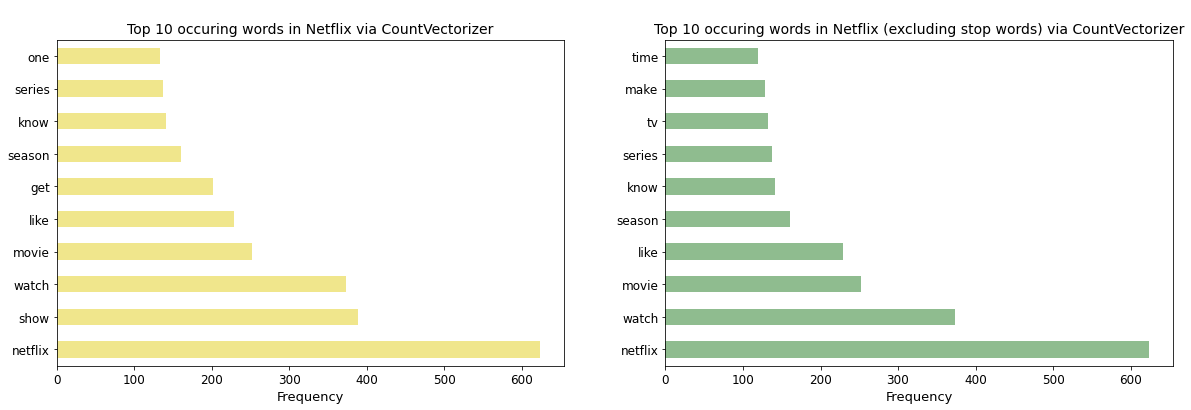

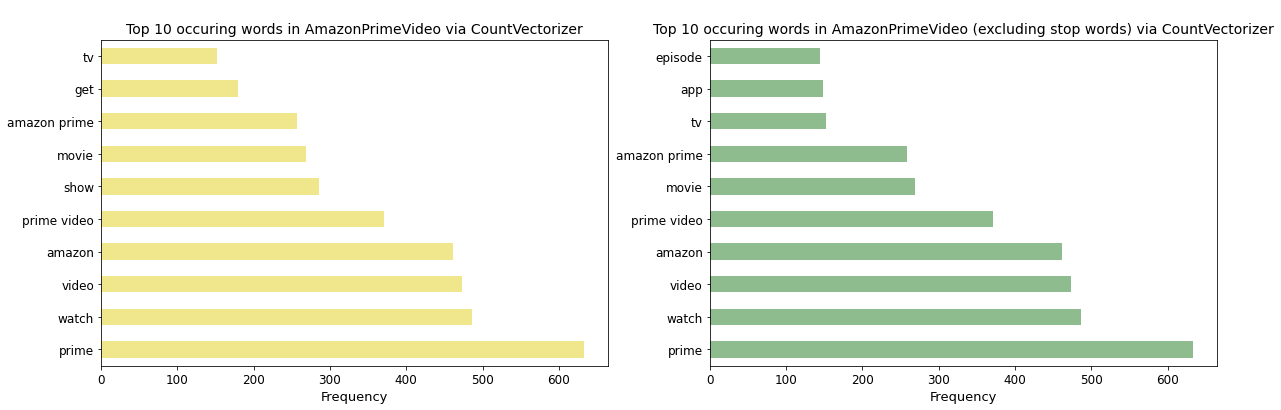

In [18]:
plot_vectorizer(netflix_cvec, netflix_cvec_stopwords, 'Netflix', 'CountVectorizer', 'Frequency')
plot_vectorizer(amazon_cvec, amazon_cvec_stopwords, 'AmazonPrimeVideo', 'CountVectorizer', 'Frequency')

From the yellow graphs, we can see that there are stopwords like 'get' and 'one' so removing stopwords again help to focus on more important words as seen in the green-colored graphs.<br>
Looking at the green-colored graphs (without stop words), I can see that there are same occuring words such as 'tv', 'season' and 'movie' and there are also different occuring words such as 'netflix' and 'amazon' which are important to help differentiate between the two subreddits. And it seems that unigrams are much more common than bigrams in terms of the top 10 words. <br>
To visualise better what are the common words and different words for both subreddits, I will use venn diagram to depict later.

In [19]:
def venndiagram(netflix_df, amazon_df, title):
    
    # calculate the count for each word
    netflix_words = netflix_df.sum(axis=0)
    
    # get the top 20 highest word and their counts
    netflix_words = netflix_words.sort_values(ascending = False).head(20)
    
    # place it in a dataframe and name the columns accordingly
    netflix_words = pd.DataFrame(netflix_words.reset_index())
    netflix_words.columns =['word', 'count']

    amazon_words = amazon_df.sum(axis=0)
    amazon_words = amazon_words.sort_values(ascending = False).head(20)
    amazon_words = pd.DataFrame(amazon_words.reset_index())
    amazon_words.columns =['word', 'count']
    
    plt.figure(figsize=(10, 8))
    plt.title('\n' + title,fontsize=20)

    set_a = set(netflix_words['word'])
    set_b = set(amazon_words['word'])

    venn = venn2([set_a,set_b],set_labels=['Netflix','Amazon'], set_colors=("lightgreen", "lightblue"),alpha=0.7)

    venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
    venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
    venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

    venn.get_label_by_id('A').set_size(18)
    venn.get_label_by_id('B').set_size(18)
    venn.get_label_by_id('100').set_size(13)
    venn.get_label_by_id('110').set_size(13)
    venn.get_label_by_id('010').set_size(13)

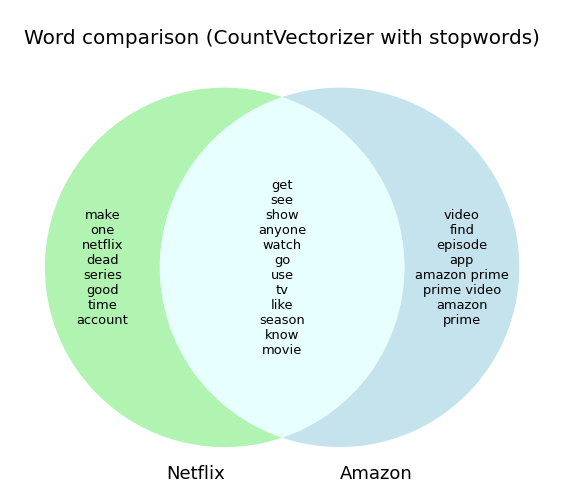

In [20]:
venndiagram(netflix_cvec, amazon_cvec, 'Word comparison (CountVectorizer with stopwords)')

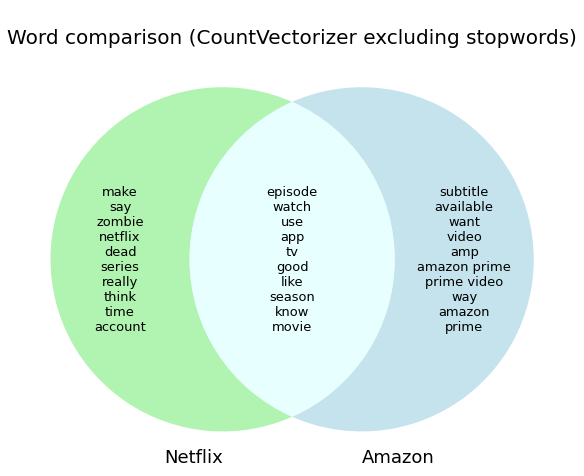

In [21]:
venndiagram(netflix_cvec_stopwords, amazon_cvec_stopwords, 'Word comparison (CountVectorizer excluding stopwords)')

We can see that there's a number of words that are the same that appear in the top 20 for both subreddits but at the same time, there are distinct words that differentiate them as well.

### **TF-IDF Vectorizer (unigrams and bigrams)**

Using the function created earlier, now I will pass through both dataframe with TF-IDF Vectorizer and see the results.

In [22]:
# input netflix dataframe into the function again, but using TF-IDF fVectorizer this time round
netflix_tvec, netflix_tvec_stopwords = vectorizer_df(netflix_df, TfidfVectorizer)

# check out the first 5 rows and 10 columns
netflix_tvec.iloc[:5, :10]

,aaron,aaron paul,aback,aback disappointing,abandon,abandon story,abduction,abduction lisa,ability,ability bring
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# check out the first 5 rows and 10 columns excluding stopwords
netflix_tvec_stopwords.iloc[:5, :10]

,aaron,aaron paul,aback,aback disappointing,abandon,abandon story,abduction,abduction lisa,ability,ability bring
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# input amazon dataframe into the function 
amazon_tvec, amazon_tvec_stopwords = vectorizer_df(amazon_df, TfidfVectorizer)

# check out the first 5 rows and 10 columns
amazon_tvec.iloc[:5, :10]

,aaron,aaron love,aaye,aaye lyric,ab,ab disgrace,abbey,abbey prime,abbey speed,abduction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# check out the first 5 rows and 10 columns excluding stopwords
amazon_tvec_stopwords.iloc[:5, :10]

,aaron,aaron love,aaye,aaye lyric,ab,ab disgrace,abbey,abbey prime,abbey speed,abduction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **TfidVectorizer Visualisation**

Now, I will visualise the top 10 occuring words by TF-IDF Vectorizer using the function created earlier as well.

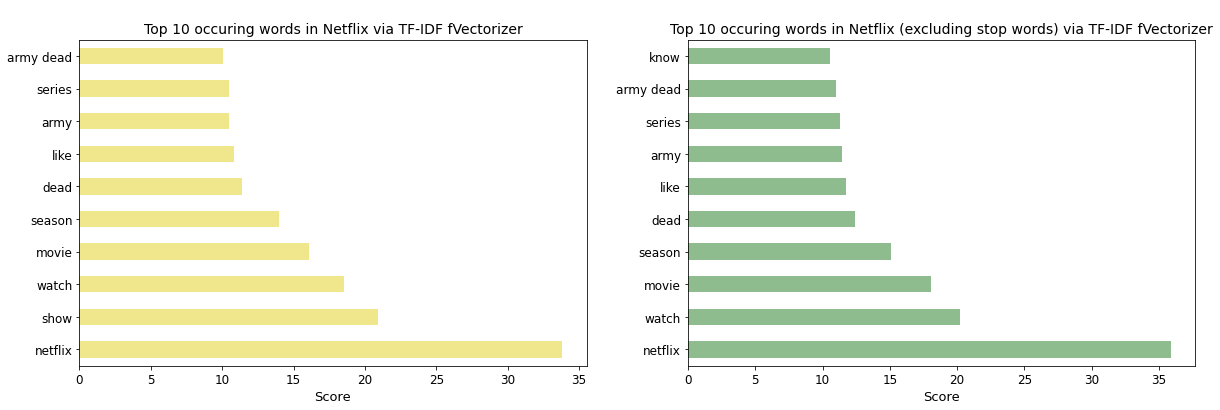

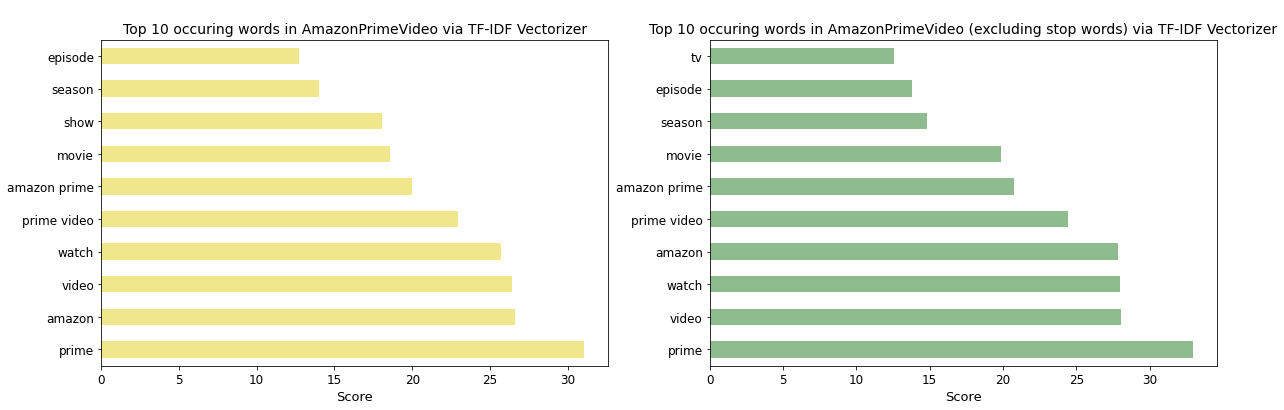

In [26]:
# using the function created earlier, plot visualisation using TF-IDF Vectorizer
plot_vectorizer(netflix_tvec, netflix_tvec_stopwords, 'Netflix', 'TF-IDF fVectorizer', 'Score')
plot_vectorizer(amazon_tvec, amazon_tvec_stopwords, 'AmazonPrimeVideo', 'TF-IDF Vectorizer', 'Score')

Though I have removed stopwords earlier when cleaning the data, we can see that there are still stopwords exist on the yellow graph such as 'one' and 'get'.
Same as CountVectorizer, looking at the green-colored graphs (without stop words), there are same occuring words such as 'movie' and 'season'. But there are also different occuring words such as 'netflix' and 'amazon prime' to help differentiate the two subreddits.

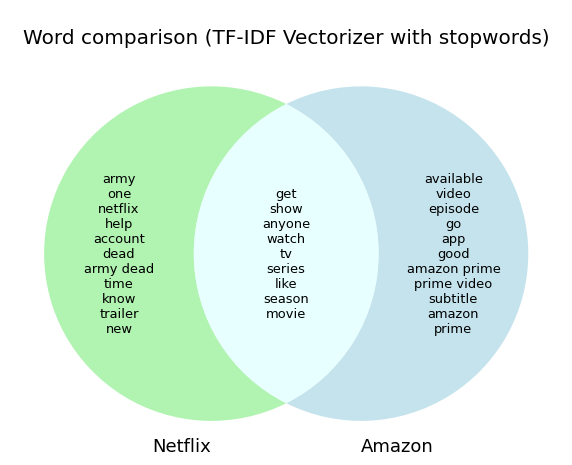

In [27]:
venndiagram(netflix_tvec, amazon_tvec, 'Word comparison (TF-IDF Vectorizer with stopwords)')

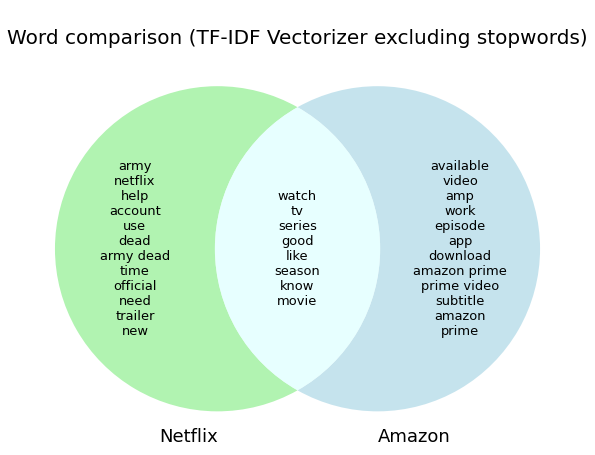

In [28]:
venndiagram(netflix_tvec_stopwords, amazon_tvec_stopwords, 'Word comparison (TF-IDF Vectorizer excluding stopwords)')

We can see that there's a number of words that are the same that appear in the top 20 for both subreddits but at the same time, there are distinct words that differentiate them as well.

Since there are distinct differences between the two subreddits, we can continue to go ahead with the modeling and see how well it works.

## **Modeling**

### **Merge both dataframe**

In [29]:
# combine both subreddits vertically into 1 dataframe
df = pd.concat([netflix_df, amazon_df])
df.head()

,subreddit,text
0,netflix,movie series recommendation
1,netflix,want download netflix download netflix want d...
2,netflix,download
3,netflix,season kim convenience netflix
4,netflix,use people netflix account long time friend n...


In [30]:
# label AmazonPrimeVideo and netflix to 0 and 1 respectively
df['subreddit'] = df['subreddit'].map({'AmazonPrimeVideo':0, 'netflix':1})
df.head()

,subreddit,text
0,1,movie series recommendation
1,1,want download netflix download netflix want d...
2,1,download
3,1,season kim convenience netflix
4,1,use people netflix account long time friend n...


In [31]:
# check out how many rows are there
df.shape

(1949, 2)

### **Create X and y for modeling**

In [32]:
# create X and y variables
X = df['text']
y = df['subreddit']

### **Baseline score**

In [33]:
y.value_counts(normalize = True)

0    0.505387
1    0.494613
Name: subreddit, dtype: float64

Based on the value counts, the percentage is pretty much the same, therefore the baseline score is 50%. Setting the baseline score at 50% means that there's a 50% accuracy the predicted subreddits is either netflix or amazon prime video.<br>
If my model can achieve >50% accuracy, it means I should consider the model to predict which subreddit it belongs to since it will generate better results than baseline score.

### **Train-test-split**

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### **RandomForest**

Random forest is a supervised learning algorithm. It is an ensemble of decision trees that aims to increase the overall result.<br> The models has two key concepts:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

<br>The final predictions of the random forest are made by averaging the predictions of each individual tree. 
<br>As random forest uses random subset of features for every tree, there's low correlation between the trees so it reduces the variance as well. It is a model that performs pretty well due to how it works.<br>
I will use GridSearchCV to search for the best parameters and see 

In [35]:
# check the best params for RandomForestClassifier
pipe_rf = Pipeline([('vec', None), ('model', RandomForestClassifier())])
param_grid_rf = {'vec': [CountVectorizer(), TfidfVectorizer()], 
              'model__n_estimators': [50, 100],
              'model__max_depth': [6, 10, 16],
              'model__min_samples_leaf': [6, 10],
              'model__min_samples_split': [16, 32],
              'model__random_state': [42],
              'vec__stop_words': ['english'],
              'vec__max_features': [1500, 2000],
              'vec__min_df': [10, 20], 
              'vec__max_df': [0.8, 0.9],
              'vec__ngram_range': [(1, 1), (1, 2)]}
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy')
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__max_depth': [6, 10, 16],
                         'model__min_samples_leaf': [6, 10],
                         'model__min_samples_split': [16, 32],
                         'model__n_estimators': [50, 100],
                         'model__random_state': [42],
                         'vec': [CountVectorizer(max_df=0.8, max_features=1500,
                                                 min_df=10, ngram_range=(1, 2),
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.8, 0.9],
                         'vec__max_features': [1500, 2000],
                         'vec__min_df': [10, 20],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': 

In [36]:
# check the best score and best params
print(f'Best score: {gs_rf.best_score_}')
print(f'Best params:  {gs_rf.best_params_}')

Best score: 0.8168582375478927
Best params:  {'model__max_depth': 16, 'model__min_samples_leaf': 6, 'model__min_samples_split': 16, 'model__n_estimators': 50, 'model__random_state': 42, 'vec': CountVectorizer(max_df=0.8, max_features=1500, min_df=10, ngram_range=(1, 2),
                stop_words='english'), 'vec__max_df': 0.8, 'vec__max_features': 1500, 'vec__min_df': 10, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}


### **Logistic Regression**

Logistic regression is the most common binary classification algorithm that predicts continuous probabilities between 0 and 1. We can use these probabilities to choose which class we predict. <br>
Advantages: The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.) <br>Logistic regression is a very fast model to fit and generate predictions from.


In [37]:
pipe_lr = Pipeline([('vec', None), ('model', LogisticRegression())])
param_grid_lr = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                'model__max_iter': [3000, 4000],
                'model__penalty': ['l1', 'l2'],
                'model__solver': ['saga'],
                'model__C': [1.0, 5.0],
                'model__random_state': [42],
                'vec__stop_words': ['english'], 
                'vec__max_features': [2000, 2500], 
                'vec__min_df': [2, 5], 
                'vec__max_df': [0.90, 0.95],
                'vec__ngram_range': [(1, 1), (1, 2)]}
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy')
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [1.0, 5.0],
                         'model__max_iter': [3000, 4000],
                         'model__penalty': ['l1', 'l2'],
                         'model__random_state': [42], 'model__solver': ['saga'],
                         'vec': [CountVectorizer(max_df=0.9, max_features=2000,
                                                 min_df=2,
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__max_df': [0.9, 0.95],
                         'vec__max_features': [2000, 2500],
                         'vec__min_df': [2, 5],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': ['english']},
             scoring='accuracy')

In [38]:
# check the best score and best params
print(f'Best score: {gs_lr.best_score_}')
print(f'Best params:  {gs_lr.best_params_}')

Best score: 0.8544061302681992
Best params:  {'model__C': 1.0, 'model__max_iter': 3000, 'model__penalty': 'l2', 'model__random_state': 42, 'model__solver': 'saga', 'vec': CountVectorizer(max_df=0.9, max_features=2000, min_df=2, stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 2000, 'vec__min_df': 2, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}


### **Multinomial Naive Bayes**

Naive Bayes is a classification model that relies on Bayes Theorem which has one underlying assumption - the features are independent of each other. It is mostly used in Natural Language Processing (NLP). <br>Advantages: it is simple and can be used for predicting real-time applications. It is also highly scalable and can easily handle large datasets. <br>Disadvantages of making the assumption of feature independence is it's unrealistic, especially in the case of text data. While our classifications are accurate, our predicted probabilities
are usually quite bad.


In [39]:
pipe_nb = Pipeline([('vec', None), ('model', MultinomialNB())])
param_grid_nb = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                 'model__alpha':[0.75,0.8,0.85],
                 'model__fit_prior':[True],
              'vec__stop_words': ['english'],
              'vec__max_features': [1500, 2000],
              'vec__min_df': [3, 10],
              'vec__max_df': [0.90, 0.99],
              'vec__ngram_range': [(1, 1), (1, 3)]}
gs_nb = GridSearchCV(pipe_nb, param_grid_nb, cv=5, scoring='accuracy')
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec', None),
                                       ('model', MultinomialNB())]),
             param_grid={'model__alpha': [0.75, 0.8, 0.85],
                         'model__fit_prior': [True],
                         'vec': [CountVectorizer(),
                                 TfidfVectorizer(max_df=0.9, max_features=1500,
                                                 min_df=3,
                                                 stop_words='english')],
                         'vec__max_df': [0.9, 0.99],
                         'vec__max_features': [1500, 2000],
                         'vec__min_df': [3, 10],
                         'vec__ngram_range': [(1, 1), (1, 3)],
                         'vec__stop_words': ['english']},
             scoring='accuracy')

In [40]:
# check the best score and best params
print(f'Best score: {gs_nb.best_score_}')
print(f'Best params:  {gs_nb.best_params_}')

Best score: 0.8222222222222222
Best params:  {'model__alpha': 0.85, 'model__fit_prior': True, 'vec': TfidfVectorizer(max_df=0.9, max_features=1500, min_df=3, stop_words='english'), 'vec__max_df': 0.9, 'vec__max_features': 1500, 'vec__min_df': 3, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}


## **Evaluation**

In [41]:
# evaluate the train and test score for all 3 models
print(' Random forest '.center(21, "="))
print(f'Train score: {gs_rf.score(X_train, y_train):.4f}')
print(f'Test score: {gs_rf.score(X_test, y_test):.4f}')
print()
print(' Logistic Regression '.center(28, "="))
print(f'Train score: {gs_lr.score(X_train, y_train):.4f}')
print(f'Test score: {gs_lr.score(X_test, y_test):.4f}')
print()
print(' Multinomial Naive Bayes '.center(31, "="))
print(f'Train score: {gs_nb.score(X_train, y_train):.4f}')
print(f'Test score: {gs_nb.score(X_test, y_test):.4f}')
print()

=== Random forest ===
Train score: 0.8498
Test score: 0.8152

=== Logistic Regression ====
Train score: 0.9617
Test score: 0.8587

=== Multinomial Naive Bayes ===
Train score: 0.9234
Test score: 0.8137



Random forest has the closest train and test accuracy score with very slight overfitting, the test score is at 0.82<br>
Logistic regression has the highest different of train and test accuracy score with overfitting, but it has the best test accuracy score of 0.85.<br>
Multinomial naive bayes has slight overfitting as well and its test score is at 0.82 <br>
Among the 3 models, Logistic regression together with CountVectorizer is the best model in terms of accuracy score.


In [42]:
def confusion_mat(model, title):
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format = 'd', 
                          display_labels=['Amazon Prime Video', 'Netflix\n'])
    plt.title(title + '\n', size=14) ;
    print(f'True Positive: {tp}')
    print(f'True Negative: {tn}')
    print(f'False Positive: {fp}')
    print(f'False Negative: {fn}')
    print()
    print(f'Accuracy: {accuracy_score(y_test, preds):.3f}')
    print(f'Sensitivity(recall): {recall_score(y_test, preds):.3f}')
    print(f'Specificity: {(tn/(tn+fp)):.3f}')
    print(f'Precision: {precision_score(y_test, preds):.3f}')
    print()

I have created a function to further look at other performances metrics such as sensitivity, specificity and precision. Though I'm choosing the model based on accuracy score, it would be good to look at other performance metrics.

True Positive: 287
True Negative: 238
False Positive: 87
False Negative: 32

Accuracy: 0.815
Sensitivity(recall): 0.900
Specificity: 0.732
Precision: 0.767



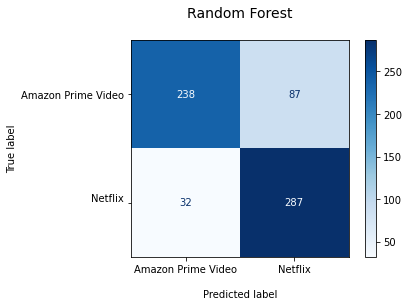

In [43]:
confusion_mat(gs_rf, 'Random Forest')

True Positive: 271
True Negative: 282
False Positive: 43
False Negative: 48

Accuracy: 0.859
Sensitivity(recall): 0.850
Specificity: 0.868
Precision: 0.863



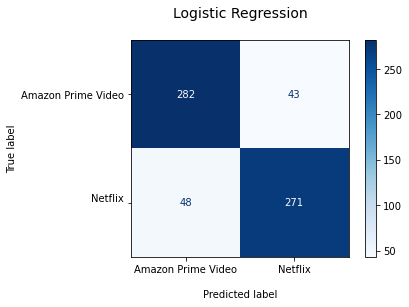

In [44]:
confusion_mat(gs_lr, 'Logistic Regression')

True Positive: 247
True Negative: 277
False Positive: 48
False Negative: 72

Accuracy: 0.814
Sensitivity(recall): 0.774
Specificity: 0.852
Precision: 0.837



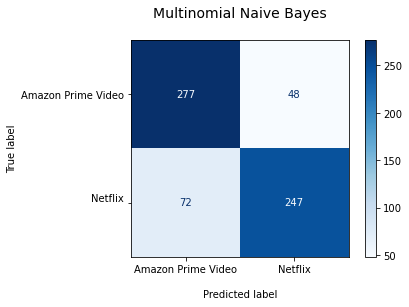

In [45]:
confusion_mat(gs_nb, 'Multinomial Naive Bayes')

Looking at the confusion matrix, Logistic regression has the lowest combined sum of False Positives and Negatives at 46+48=94, whereas Random forest has total 114 False Positives and Negatives, Multinomial Naive Bayes has total 115 False Positives and Negatives. <br>
Logistic regression with CountVectorizer has the best balance of recall, specificity and precision scores, which further confirm that it's the best model to classify Amazon Prime Video and Netflix subreddits.


## **Conclusions and recommendations**

Based on the results of the 3 models, I would recommend Logistic regression with CountVectorizer to do the classification of Netflix and Amazon Prime Video subreddits which will help with categorising current and future WhatToWatch posts with at least 85% accuracy.  <br>
To increase the accuracy further, I will pull more data and see if the score can be improved. Compared to the baseline accuracy of 50%, Logistic regression is a good model to classify and predict the posts as it has a higher accuracy of 85% <br>
I will also consider looking at other reputable sources other than subreddits and use its data as a standalone or combine with the existing subreddits' data to see if the accuracy score can be improved.

Being part of Skippy data science team, I can use this model to address other clients' classification problems by pulling the data they want to reference to and use Logistic regression with CountVectorizer. The limitation of Logistic regression is that it only work for two-class classification problems, therefore, if I want to classify more than 2 categories/classes, this model would not be suitable. In that case, I would need to consider using Random forest, Multinomial Naive Bayes or even introduce a new model - Multinomial logistic regression and see which model works better for multi-class classification.<br>